For reference, when n = 30 it took 5 hours to train the neural network and it produced garbage. Please limit n to a resonable number (say n <10).
Which to spare you the ~20 minutes of training, n = 9 is okay, it matches mostly well, but has a bunch of anomalies.

In [292]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim

We start by setting the size of the well, the quantum number (n), the number of steps in space and time, as well as the amount of time we want to simulate.

In [301]:
L = 2
n = 6
T = 8
num_x_steps = 200
num_t_steps = 5
hbar = 1.054*10**(-34)
m = 9.109*10**(-34) #This is so time effects are actually seen
x = np.linspace(0,L,num_x_steps)
t = np.linspace(0,T,num_t_steps)

We now use the analytical method with the following wave equation:

$$ \psi_n(x) = \sqrt{\frac{2}{L}}sin(\frac{n\pi x}{L})e^{iE_nt/\hbar} $$

We also use the Schrödinger Equation:

$$\frac{-\hbar^2}{2m}\frac{\delta^2}{\delta x^2}\psi(x,t) = i\hbar \frac{\delta}{\delta t}\psi(x,t) $$

Now $E_n$ is equal to (solved from Schrödinger Equation):

$$ \frac{\hbar^2}{2m}(\frac{n\pi}{L})^2 = E_n $$

Now add the E_n to the wave equation:

$$ \psi_n(x,t) = \sqrt{\frac{2}{L}}sin(\frac{n\pi x}{L})e^{-i\frac{\hbar n^2\pi^2 t}{2mL^2}} $$

Superposition:

$$ \psi(x,t) = \sum_{n=1}^{n}C_n\psi_n(x,t) $$

Where:

$$C_n = -\frac{sin(2\pi n) - 2\pi n}{2\pi n}$$

Now model the wave analytically over time and space:

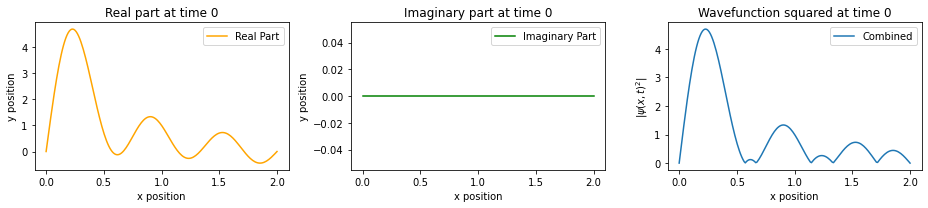

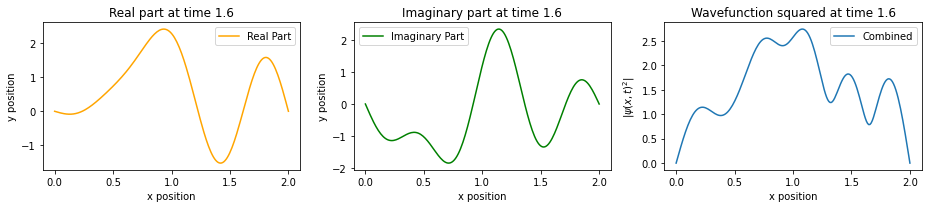

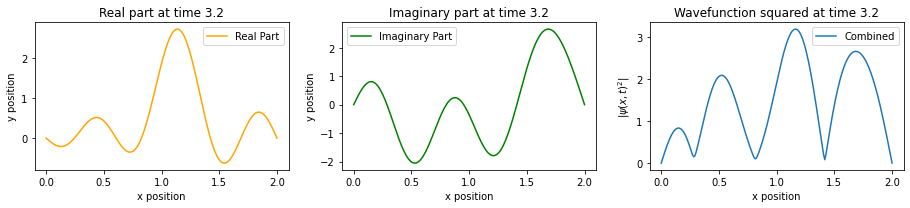

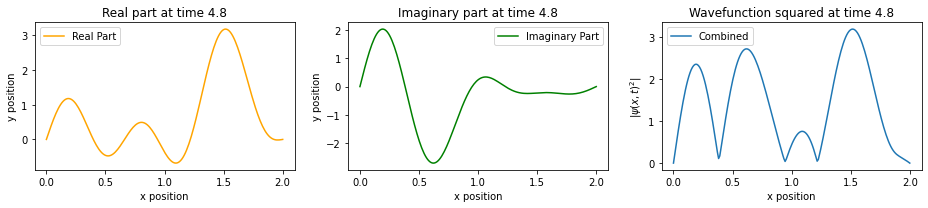

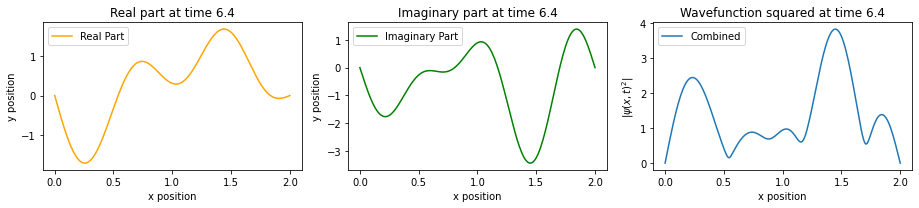

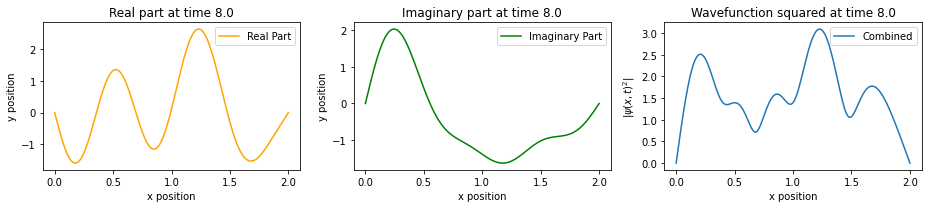

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/205385858.py:55: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[0]*np.pi**2*hbar**2/(2*m*F_val[0]), label = "Analytical Energy Calculated")


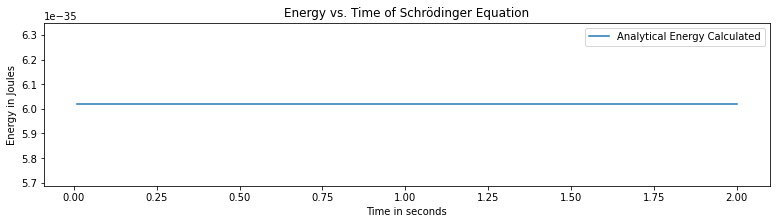

In [302]:
t1 = 0
steps = 0
t1_array = []

def wave_equation(x,t,L,n,hbar,m): #This is the analytical wave equation
    waves = []
    for i in range(1,n+1):
        C = -(np.sin(2*np.pi*i) - (2*np.pi*i))/(2*np.pi*i)
        W = (2/L)**0.5 * np.sin(i*np.pi*x/L)*np.exp(-complex(0,1)*hbar*np.pi**2*(i**2)*t/(2*m*L**2))
        waves.append(C*W)
    return sum(waves) #The summing is the sum of all the wave equations from different n values

def Energy_eq(hbar, n, m, L): #Analytical calculation for energy
    return (hbar*n*np.pi)**2/(2*m*L**2)

numpy_tracker = 0
T_val = []
X_val = []
F_val = []

record_for_NN = []

while(t1 <= T):
    plt.figure(figsize=(13,3))
    ax = plt.subplot(1,3,1)
    wave_superposition = wave_equation(x,t1,L,n,hbar,m)
    ax.plot(x, wave_superposition.real, label = "Real Part", color = 'orange')
    plt.xlabel("x position")
    plt.ylabel('y position')
    plt.title(f"Real part at time {round(t1,1)}")
    plt.legend()
    ax = plt.subplot(1,3,2)
    ax.plot(x, wave_superposition.imag, label = "Imaginary Part", color = 'green')
    plt.xlabel("x position")
    plt.ylabel('y position')
    plt.title(f"Imaginary part at time {round(t1,1)}")
    plt.legend()
    ax = plt.subplot(1,3,3)
    ax.plot(x, (wave_superposition.imag**2+wave_superposition.real**2)**0.5, label = "Combined")
    record_for_NN.append((wave_superposition.imag**2+wave_superposition.real**2)**0.5)
    plt.xlabel("x position")
    plt.ylabel('$|\psi(x,t)^2|$')
    plt.title(f"Wavefunction squared at time {round(t1,1)}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    T_val.append([t1]*len(x))
    X_val.append(x)
    F_val.append((wave_superposition.imag**2+wave_superposition.real**2)**0.5)
    t1_array.append(t1)
    t1 += T/num_t_steps
    steps += 1
    
plt.figure(figsize=(13,3))
plt.plot(x, F_val[0]*np.pi**2*hbar**2/(2*m*F_val[0]), label = "Analytical Energy Calculated")
plt.xlabel("Time in seconds")
plt.ylabel("Energy in Joules")
plt.title("Energy vs. Time of Schrödinger Equation")
plt.legend()
plt.show()

Note: The true divide happens at the borders (0.0, 2.0) since it's 0. For now we ignore this since it works.

Using PINN method

First we Convert the previous data (from Analytical) to Torch:

In [303]:
X_val_PINN = torch.FloatTensor(X_val).float().reshape(-1,1)
T_val_PINN = torch.FloatTensor(T_val).float().reshape(-1,1)
F_val_PINN = torch.FloatTensor(F_val).float().reshape(-1,1)

Next we train the Neural Network. What's important to note is that with higher n values more "variability" is added to the wave, to train the NN, more learning layers have to be added as to combat the "randomness" of the wave. This is done by running a for loop within the Neural Net.

In [304]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.il  = nn.Linear(2,20) 
        self.hl1 = nn.Linear(20, 100)
        self.hl2 = nn.Linear(100, 200)
        self.hl = nn.Linear(200,200)
        self.hl3 = nn.Linear(200,100) 
        self.hl4 = nn.Linear(100,20) 
        self.ol  = nn.Linear(20,1) 
        self.tn  = nn.Tanh()
        self.elu  = nn.ELU()

    def forward(self, x, y):
        global n
        u = torch.cat((x, y), 1)
        u = self.il(u)
        u = self.elu(u)
        u = self.hl1(u)
        u = self.elu(u)
        u = self.hl2(u)
        u = self.elu(u)
        for i in range(n+1):
            u = self.hl(u)
            u = self.elu(u)
        u = self.hl3(u)
        u = self.elu(u)
        u = self.hl4(u)
        u = self.elu(u)
        u = self.ol(u)
        return u

Compared to the neuralnet_fitting_demo, I've had to change the lr value to what I experimentally found to be ideal. As well as increase the epocs due to the complexity of the function and accuracy desired. It may take more than a minute to train depending on n chosen, as this is linked to the number of epochs trained.

!! BE WARNED, epocs = 1000*n !!

In [305]:
NN_model = MLP()
epocs = 1000*n
loss_evol = []
optimizer = optim.Adam(NN_model.parameters(), lr=0.0000999)
n_batches = 10
loss_fn = nn.MSELoss()

3.3333333333333335 % done
6.666666666666667 % done
10.0 % done
13.333333333333334 % done
16.666666666666664 % done
20.0 % done
23.333333333333332 % done
26.666666666666668 % done
30.0 % done
33.33333333333333 % done
36.666666666666664 % done
40.0 % done
43.333333333333336 % done
46.666666666666664 % done
50.0 % done
53.333333333333336 % done
56.666666666666664 % done
60.0 % done
63.33333333333333 % done
66.66666666666666 % done
70.0 % done
73.33333333333333 % done
76.66666666666667 % done
80.0 % done
83.33333333333334 % done
86.66666666666667 % done
90.0 % done
93.33333333333333 % done
96.66666666666667 % done
100.0 % done
Done


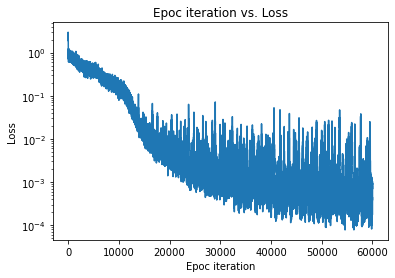

In [306]:
for epoc in range(1, epocs+1):
    n_points = X_val_PINN.shape[0]
    idxs_shuffle = np.random.choice(n_points, size = n_points, replace = False)
    for i in range(n_batches):
        X_batch = X_val_PINN[idxs_shuffle[i::n_batches],:]
        T_batch = T_val_PINN[idxs_shuffle[i::n_batches],:]
        F_batch = F_val_PINN[idxs_shuffle[i::n_batches],:]
        output_batch = NN_model(X_batch, T_batch)
        loss = loss_fn(output_batch, F_batch)
        loss_evol.append(loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoc%200 == 0):
        print(f"{epoc/epocs*100} % done")
print("Done")
plt.semilogy(loss_evol)
plt.ylabel('Loss')
plt.xlabel('Epoc iteration')
plt.title("Epoc iteration vs. Loss")
plt.show()

Now we can Model the NN created Wave vs. the analytical one. As well as graph the abolsute error between the two.

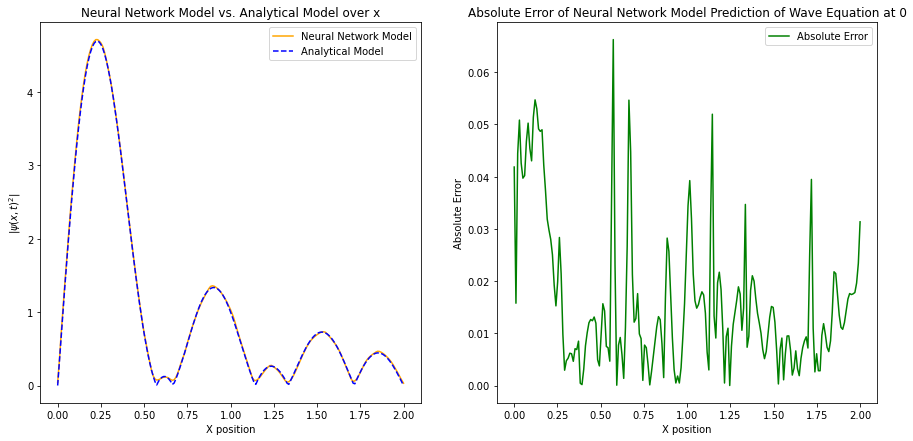

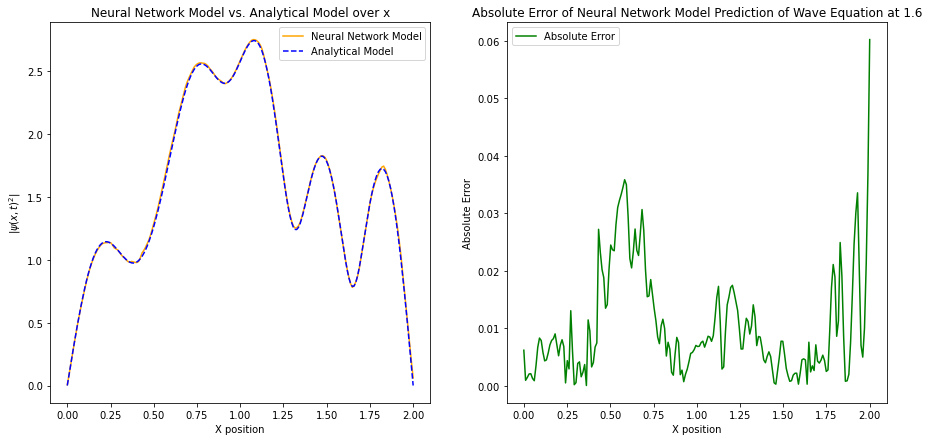

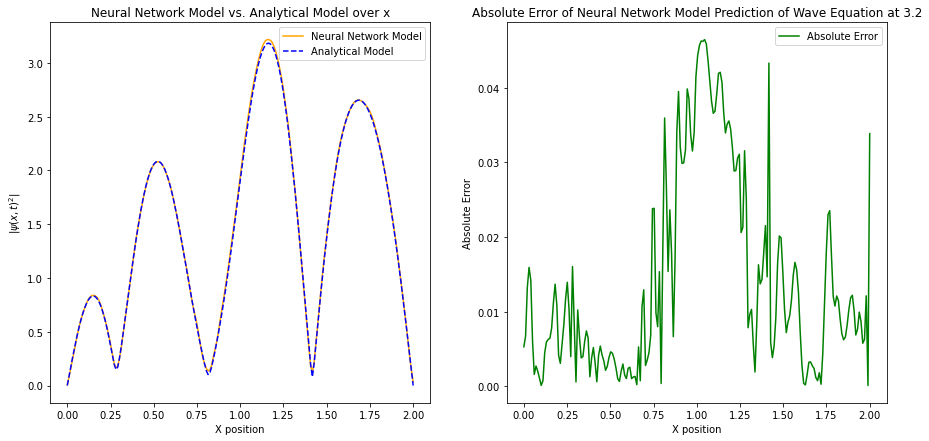

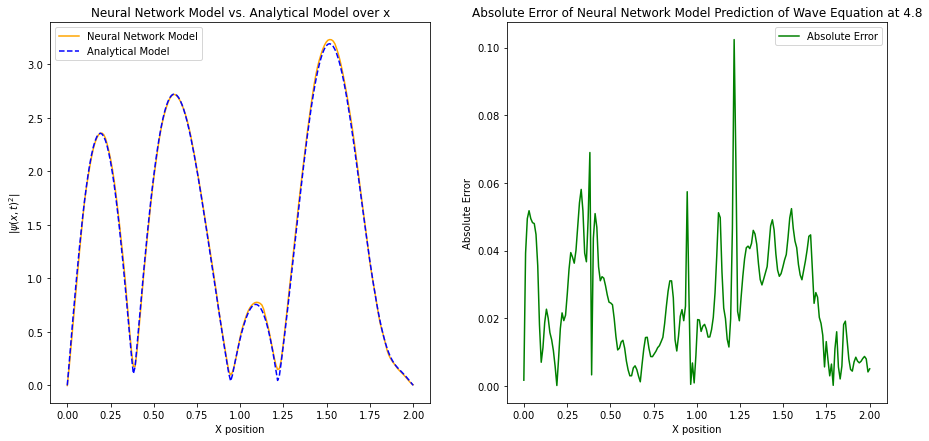

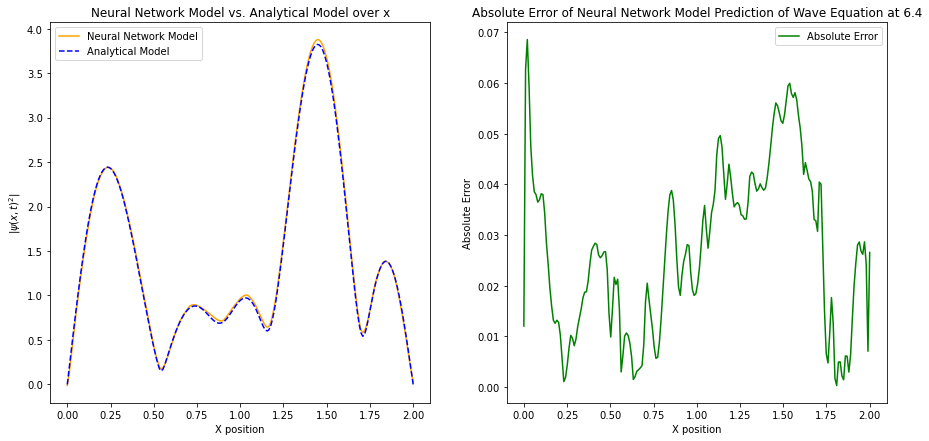

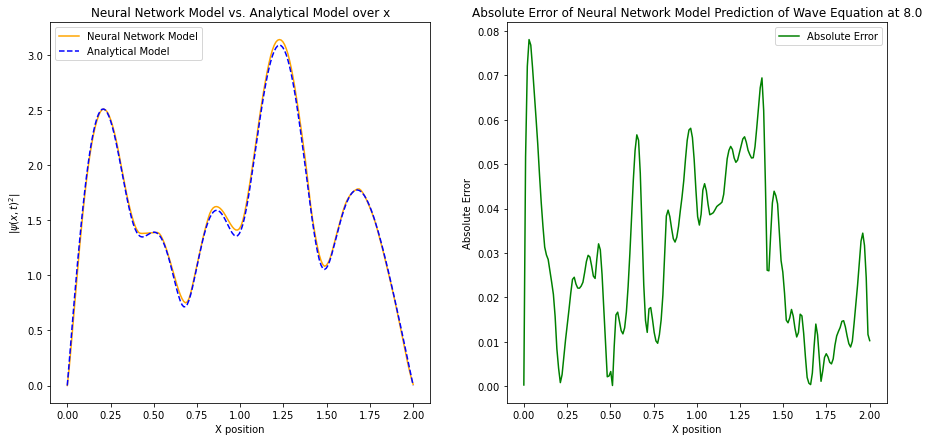

In [307]:
nx = x.shape[0]
F_val_PINN_hat = (NN_model(X_val_PINN, T_val_PINN)).T

numpy_f_val_hat = F_val_PINN_hat.detach().numpy()
numpy_f_val_hat = numpy_f_val_hat[0]

f_val_hat_reshape = np.reshape(numpy_f_val_hat, (steps, nx))

flag_NN = 0

for array in f_val_hat_reshape:
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,2,1)
    plt.title('Neural Network Model vs. Analytical Model over x')
    plt.ylabel("$|\psi(x,t)^2|$")
    plt.xlabel("X position")
    plt.plot(x, array, label = "Neural Network Model", color = 'orange')
    plt.plot(x, record_for_NN[flag_NN], label = "Analytical Model", color = 'blue', linestyle = '--')
    plt.legend()
    ax = plt.subplot(1,2,2)
    plt.plot(x, abs(record_for_NN[flag_NN]-array), label = "Absolute Error", color = 'green', linestyle = '-')
    plt.title(f"Absolute Error of Neural Network Model Prediction of Wave Equation at {round(T_val[flag_NN][0],1)}")
    plt.ylabel("Absolute Error")
    plt.xlabel("X position")
    plt.legend()
    plt.show()
    flag_NN += 1

Now that we have simulated the wave with a Neural Network, let's calculate the energy with the following equation.

$$ E = \frac{\pi^2 \hbar^2}{2m} \frac{\psi_{Neural Network}}{\psi_{Analytical}} $$

We use the neural network calculated wave equation and the Analytical one so that the difference between the two methods can be seen (since the energy equation is mostly wave independent).

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')


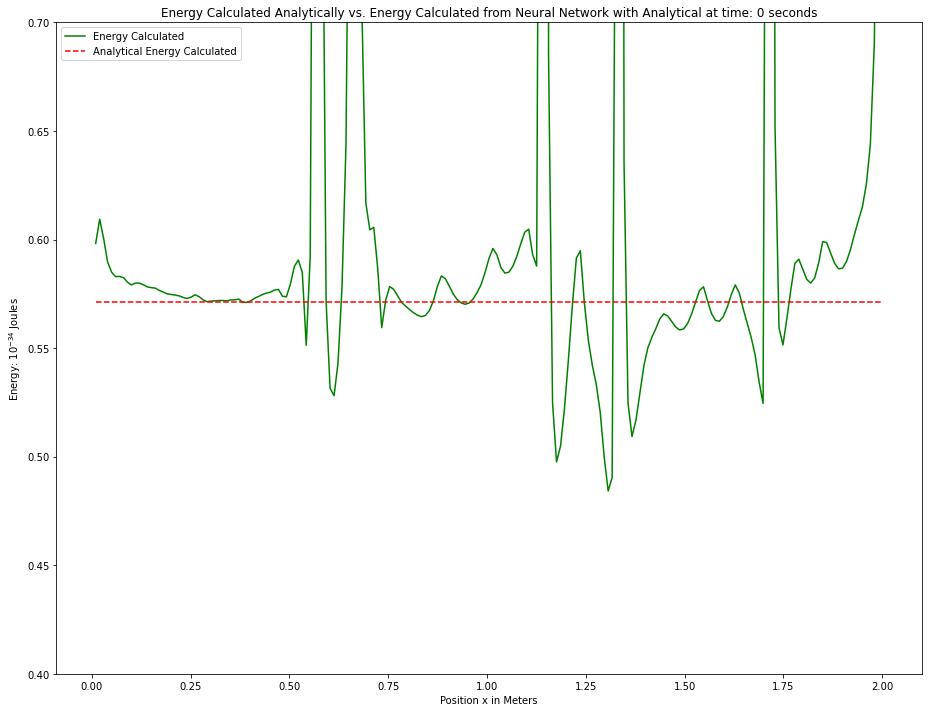

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')


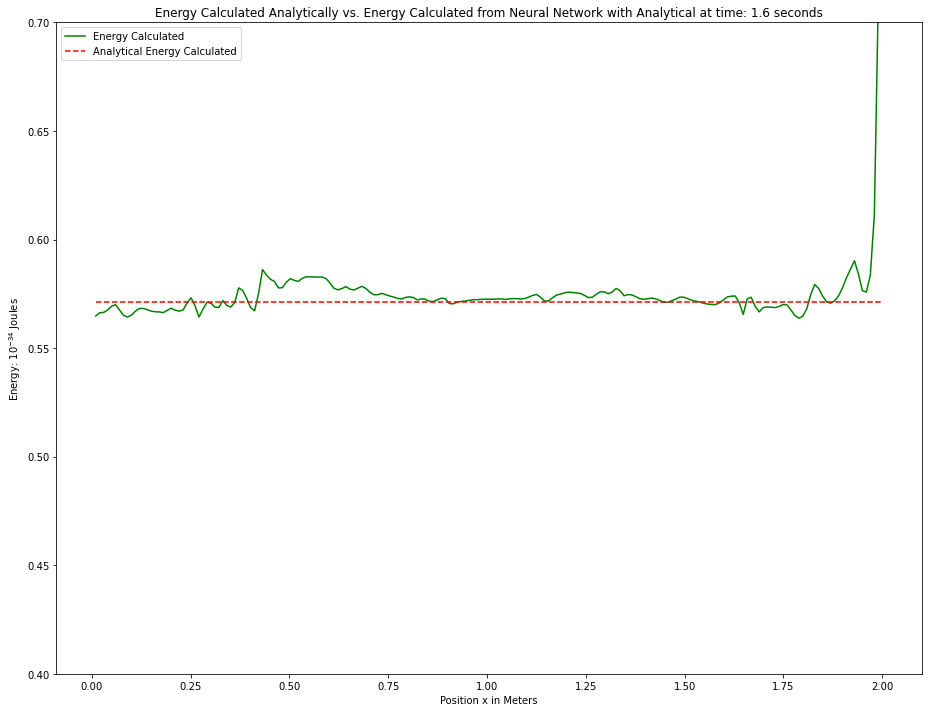

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')


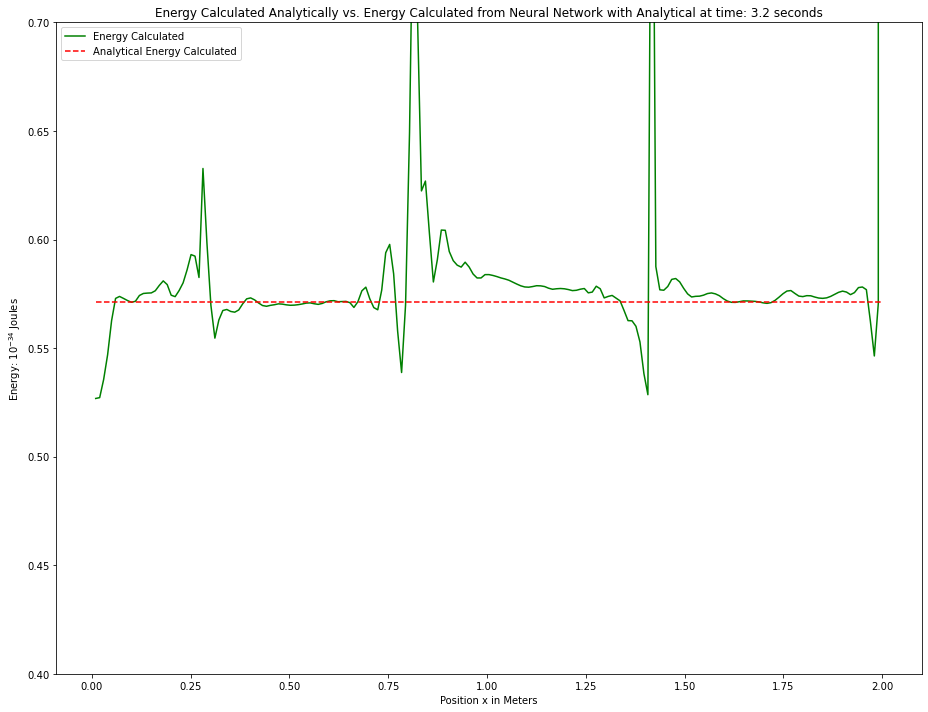

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')


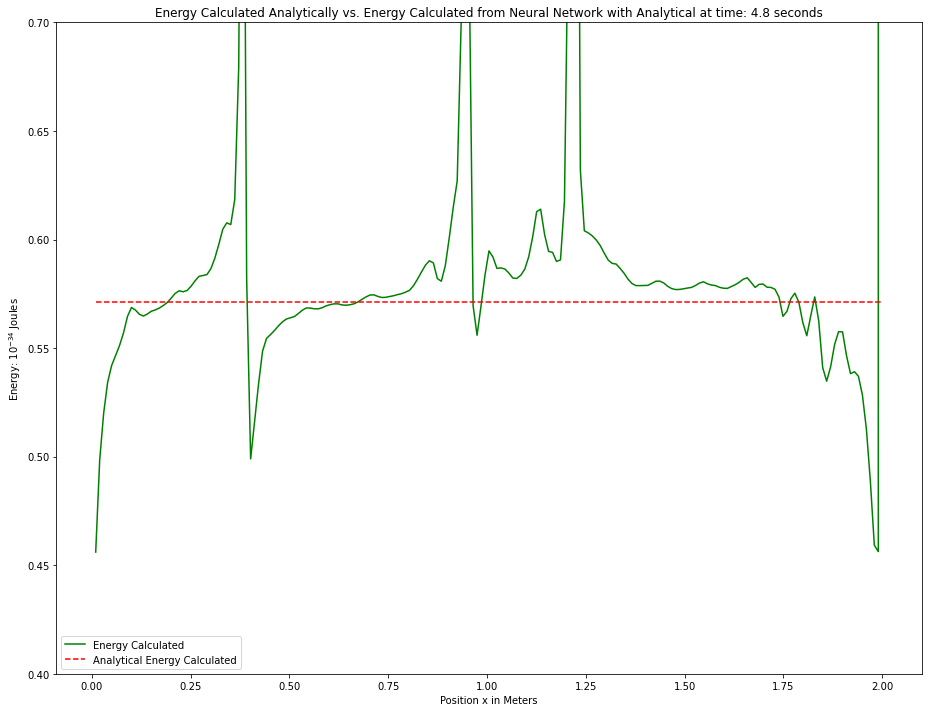

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')


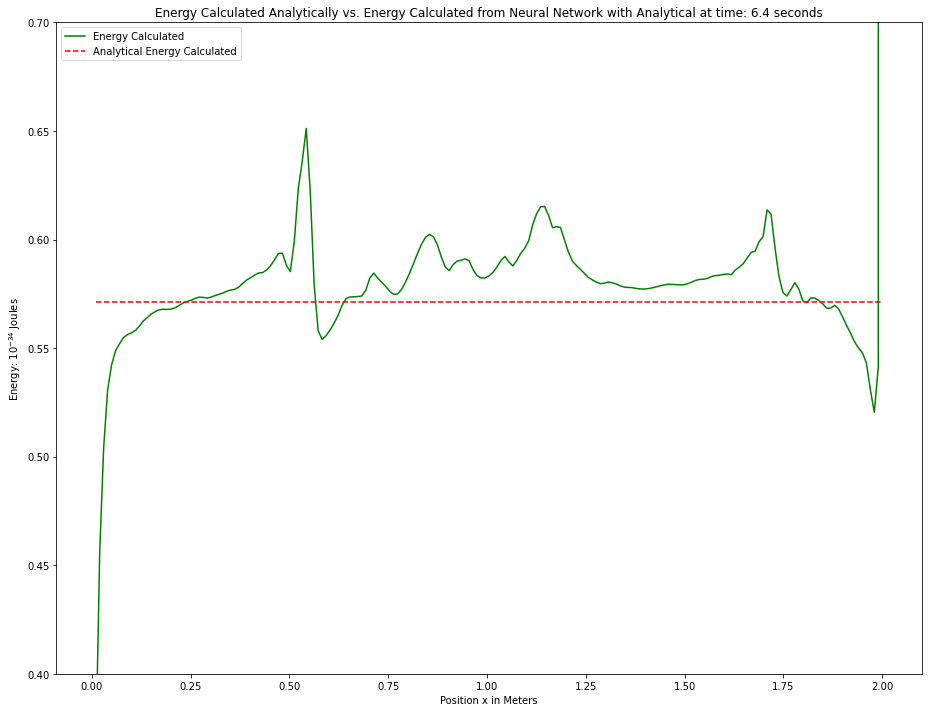

C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
C:\Users\nvbue\AppData\Local\Temp/ipykernel_22588/4118563026.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')


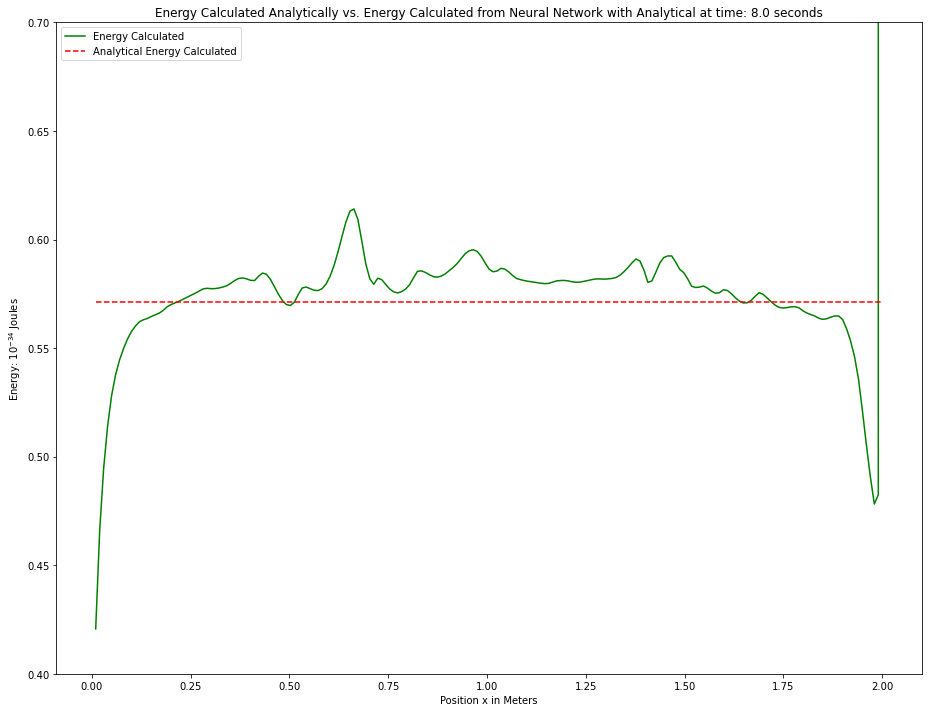

In [308]:
Energy = []
for element in range(0,len(F_val)):
    Energy.append(f_val_hat_reshape[element]*np.pi**2*hbar/(2*m*F_val[element]))
    plt.figure(figsize=(13,10))
    plt.plot(x, Energy[element], label = "Energy Calculated", color = "green")
    plt.plot(x, F_val[element]*np.pi**2*hbar/(2*m*F_val[element]), label = "Analytical Energy Calculated", color = 'Red', linestyle = '--')
    plt.title(f"Energy Calculated Analytically vs. Energy Calculated from Neural Network with Analytical at time: {round(t1_array[element],1)} seconds")
    plt.ylabel("Energy: $10^{-34}$ Joules")
    plt.xlabel("Position x in Meters")
    plt.ylim((0.4,0.7))
    plt.legend()
    plt.tight_layout()
    plt.show()

These graphs are interesting because they show interesting anomolies that do not occur with the analytical method. This is due to the fact that at these anomalies the errors between the PINN method and the Analytical method are amplified. This being anywhere where the PINN method does not produce a good estimation and also at the ends where a small error amplifies due to division in the energy equation. Specifically where there are sharp corners.
